# TimerMixerPP Tutorial

##  Environment Setup

In [ ]:
!pip install -r requirements.txt

### eval -> eval_mixerpp.py

#### 1 Package Import

In [ ]:
import json
import os
import argparse
import numpy as np
import logging
import torch
import torch.distributed as dist
from torch.utils.data import DistributedSampler, DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM
from modeling.datasets.benchmark_dataset import ChannelEvalDataset

#### 2 eval_mixerpp.py

`UnifiedTS` is a utility class for loading and performing inference with time series forecasting models. By initializing this class, you can easily load a model onto a specified device and perform batch predictions, making it suitable for model evaluation or real-world inference scenarios.

In [6]:
class UnifiedTS:
    def __init__(self, model_path, device, context_length, prediction_length, **kwargs):
        from modeling.models.modeling_UnifiedTS import UnifiedTSForPrediction,UnifiedTSConfig
        self.model = UnifiedTSForPrediction.from_pretrained(
            model_path,
            torch_dtype="auto"
        )
        self.device = device
        self.model = self.model.to(self.device) 
        self.prediction_length = prediction_length
        self.model.eval()

    def predict(self, batch):
       
        inputs = batch['inputs'].to(self.device)
        labels = batch['labels'].to(self.device)
        outputs = self.model(input_ids=inputs, labels=labels)

        preds = outputs.logits if isinstance(outputs.logits, list) else [outputs.logits]
        labels_slices = [labels[:, :pl] for pl in self.model.config.pred_len]
        return preds, labels_slices

#### Model Evaluation Workflow
The `evaluate` function provides a complete workflow for evaluating a time series forecasting model on a benchmark dataset. The process includes model loading, data preparation, batch inference, and metric calculation.

##### 1. Initialize Model and Device
First, set up the device (GPU or CPU) and load the forecasting model using the `UnifiedTS` class.

In [ ]:

batch_size = 1
context_length = 96
prediction_lengths = [96, 192, 336, 720]
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "mps"
model = UnifiedTS(
    "aeiiou/TimeMixerPP_50M",
    device,
    context_length=context_length,
    prediction_length=prediction_lengths,
    channel_mixing=True
)

##### 2. Prepare Evaluation Metrics
Create a dictionary to store MSE and MAE metrics for each prediction length.

In [8]:
global_metrics = {pl: {'mse': 0.0, 'mae': 0.0, 'count': 0} for pl in prediction_lengths}



##### 3. Loop Over Prediction Lengths and Evaluate
For each prediction length, load the evaluation dataset, create a DataLoader, and compute metrics batch by batch.

In [15]:
for pl in prediction_lengths:
        dataset = ChannelEvalDataset(
            "data/test/data_traffic_test",
            context_length=context_length,
            prediction_length=pl
        )
        test_dl = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            prefetch_factor=2,
            drop_last=False
        )
        local_mse = 0.0
        local_mae = 0.0
        local_count = 0
        with torch.no_grad():
            for batch in tqdm(test_dl, desc=f"Testing pl={pl}"):
                all_preds, all_labels = model.predict(batch)
                for pred, label, pred_len in zip(all_preds, all_labels, model.model.config.pred_len):
                    if pred_len == pl:
                        pred = pred.squeeze(-1)
                        label = label.squeeze(-1)
                        break
                break
        break


Testing pl=96:   0%|          | 0/3413 [00:40<?, ?it/s]


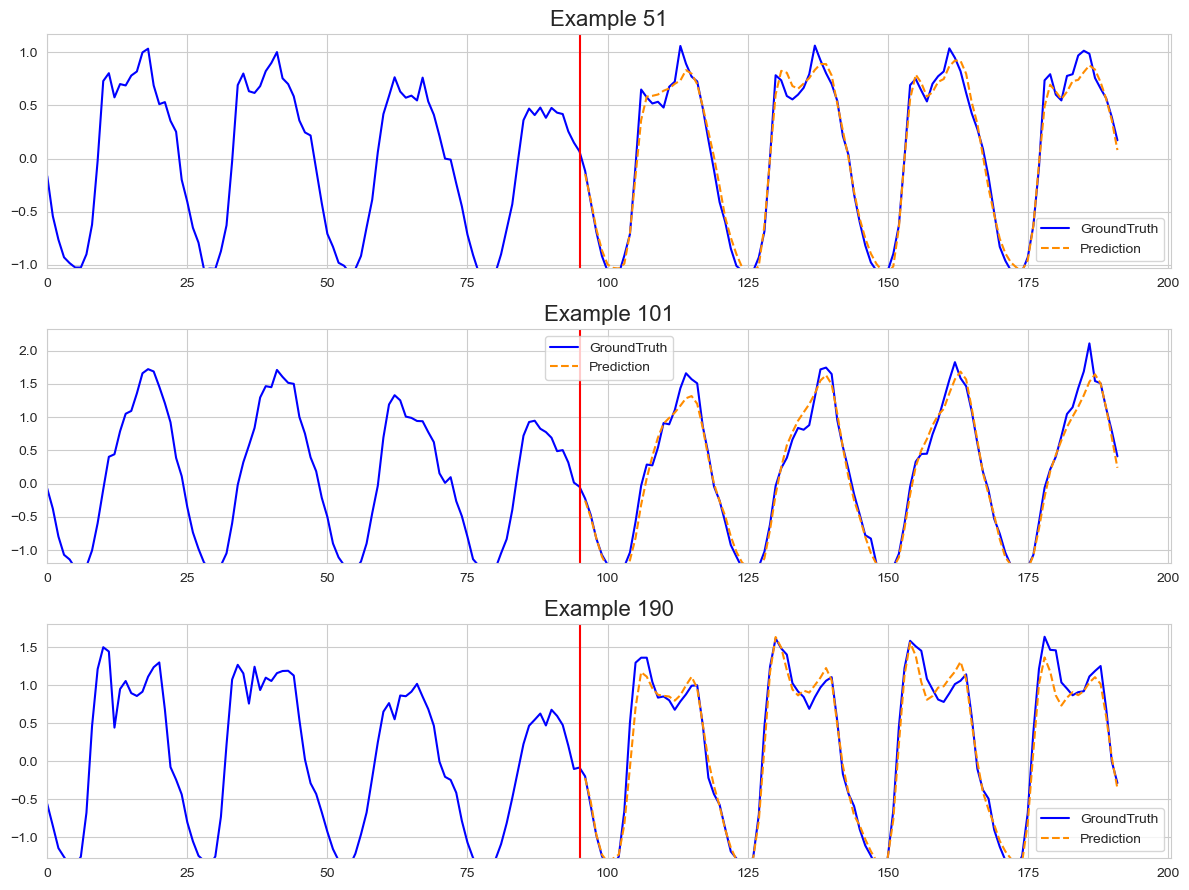

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series_comparison(context, label, pred, variable_indices, title_prefix="Variable"):
    """
    Visualizes a comparison between ground truth and predictions for time series data.

    Args:
        context (np.array): Historical data, shape (context_len, n_vars).
        label (np.array): Ground truth future data, shape (pred_len, n_vars).
        pred (np.array): Predicted future data, shape (pred_len, n_vars).
        variable_indices (list): A list of variable indices to plot.
        title_prefix (str): Prefix for the title of each subplot.
    """
    sns.set_style("whitegrid")

    num_plots = len(variable_indices)
    context_len = context.shape[0]
    pred_len = label.shape[0]

    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), squeeze=False)

    for i, var_idx in enumerate(variable_indices):
        # Note: Using squeeze=False in subplots, so 'axes' is always a 2D array.
        # This makes indexing consistent: axes[i, 0]
        ax = axes[i, 0]

        # Prepare x-axis time steps
        x_context = np.arange(0, context_len)
        x_future = np.arange(context_len, context_len + pred_len)

        # Combine context and label for a continuous ground truth line
        ground_truth_full = np.concatenate([context[:, var_idx], label[:, var_idx]])

        # Plotting
        ax.plot(np.arange(0, context_len + pred_len), ground_truth_full,
                color='blue', linestyle='-', label='GroundTruth')
        ax.plot(x_future, pred[:, var_idx],
                color='darkorange', linestyle='--', label='Prediction')

        # Add a vertical line to separate context from prediction
        ax.axvline(x=context_len - 1, color='red', linestyle='-', linewidth=1.5)

        # Formatting
        ax.set_title(f"{title_prefix} {var_idx}", fontsize=16)
        ax.legend()
        ax.set_xlim(left=0)

        min_val = min(ground_truth_full.min(), pred[:, var_idx].min())
        max_val = max(ground_truth_full.max(), pred[:, var_idx].max())
        ax.set_ylim(bottom=min_val * 0.9, top=max_val * 1.1)

    # Adjust subplot params for a tight layout
    plt.tight_layout()
    plt.show()

plot_time_series_comparison(
    context=batch["inputs"].squeeze(0).cpu().numpy(),
    label=batch["labels"].squeeze(0).cpu().numpy(),
    pred=pred.squeeze(0).cpu().numpy(),
    variable_indices=[51, 101, 190],
    title_prefix="Example"
)


#### Running the Evaluation Script
You can evaluate your trained model using the `eval_mixerPP.py` script. Specify the dataset path, enable channel mixing, set the batch size, and provide the model path as follows:

In [ ]:
python eval_model.py \
    -d data/test/data_etth1_train/ \
    --channel_mixing True \
    --batch_size 1024 \
    --model_path logs/timemixerpp

#### Fine-tuning Process
This project supports fine-tuning a pretrained time series forecasting model on these datasets . The fine-tuning workflow is managed by the `main.py` script, which configures the training process and launches model training via the `Runner` class.

##### 1. Fine-tuning Workflow Overview
- Argument Parsing:
`main.py` uses `argparse` to parse a wide range of training and model parameters, such as model path, data paths, batch size, learning rates, and more.
- Runner Initialization:
The script initializes a `Runner` object, which manages the training process.
- Training Start:
The `train_model` method is called to start fine-tuning, using the provided configuration.

In [ ]:
# main.py (simplified)
from modeling.runner import Runner

if __name__ == '__main__':
    # Parse command-line arguments
    parser = argparse.ArgumentParser()
    # ... (argument definitions) ...
    args = parser.parse_args()

    runner = Runner(
        model_path=args.model_path,
        output_path=args.output_path,
        seed=args.seed,
    )

    runner.train_model(
        model_name=args.model_name,
        from_scratch=args.from_scratch,
        context_length=args.context_length,
        prediction_length=args.prediction_length,
        # ... (other training parameters) ...
    )


##### 2. Distributed Training Launcher
For efficient training on multiple GPUs, use the `torch_dist_run.py` script. This script automatically launches distributed training using `torchrun` if GPUs are available.

##### 3. Example Fine-tuning Command
You can start fine-tuning your model with a command like the following:

In [ ]:
python torch_dist_run.py main.py \
    --micro_batch_size 1 \
    --global_batch_size 8 \
    --channel_mixing True \
    -o logs/timemixerpp_traffic_finetune \
    -d data/train/data_electricity_train/ \
    -m /opt/tiger/UnifiedTSLib/logs/timemixerpp_1 \
    --val_data_path data/val/data_electricity_validation/


- `main.py`: The main training script.
- `--micro_batch_size`: Per-GPU batch size.
- `--global_batch_size`: Total batch size across all GPUs.
- `--channel_mixing True`: Enable channel mixing.
- `-o`: Output directory for logs and checkpoints.
- `-d`: Path to the training dataset.
- `-m`: Path to the pretrained model to be fine-tuned.
- `--val_data_path`: Path to the validation dataset.